In [1]:
import pandas as pd
import numpy as np
import pickle
import gc
from pathlib import Path
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, utils, localizer

2024-03-01 20:47:06.799094: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 20:47:06.799157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 20:47:06.799965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 20:47:06.805832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 20:47:07.713660: W tensorflow/compiler/tf2

In [2]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1_v2/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

# challenge_data_dir = Path('submission/dataset/')
# data_dir = challenge_data_dir / "test"
# labels_dir = challenge_data_dir / 'test_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir, dtype=np.float32)

#some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:900]}

In [3]:
ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes,
                                      non_transform_features=['Eccentricity',
                                                              'Semimajor Axis (m)',
                                                              'Inclination (deg)',
                                                              'RAAN (deg)',
                                                              #'Argument of Periapsis (deg)',
                                                              #'True Anomaly (deg)',
                                                              #'Longitude (deg)',
                                                              'Latitude (deg)'],
                                      diff_transform_features=[#'Eccentricity',
                                                              #'Semimajor Axis (m)',
                                                              #'Inclination (deg)',
                                                              #'RAAN (deg)',
                                                              #'Argument of Periapsis (deg)',
                                                              #'True Anomaly (deg)',
                                                              #'Longitude (deg)',
                                                              #'Latitude (deg)'
                                                              ],
                                      sin_transform_features=['Argument of Periapsis (deg)',
                                                              'Longitude (deg)',
                                                              'True Anomaly (deg)'],
                                      sin_cos_transform_features=[],
                                      overview_features_mean=[#'Longitude (sin)',
                                                              #'RAAN (deg)'
                                                               ],
                                      overview_features_std=[#'Latitude (deg)'
                                                             ],
                                      add_daytime_feature=False,
                                      add_yeartime_feature=False,
                                      add_linear_timeindex=False,
                                      with_labels=True,
                                      nonbinary_padding=[110.0],
                                      train_val_split=0.8,
                                      input_stride=2,
                                      padding='zero',
                                      input_history_steps=128,
                                      input_future_steps=32,
                                      per_object_scaling=False,
                                      scale=True,
                                      custom_scaler=None,
                                      unify_value_ranges=True,
                                      input_dtype=np.float32,
                                      sort_inputs=True,
                                      seed=11)

=========================Creating Generator=======================
Seed: 11
nTrain: 1520 nVal: 380 (0.80)
Padding: zero
Horizons: 128-32 @ stride 2
Scaling: True  
Limiting True Anomaly to [0.0, 360.0] and Longitude to [-180.0, 180.0]
Sin-Transforming features: ['Argument of Periapsis (deg)', 'Longitude (deg)', 'True Anomaly (deg)']
Sin-Cos-Transforming features: []
Padding node locations in non-binary fashion ([110.0])
Final 8 input features: ['Argument of Periapsis (cos)', 'Eccentricity', 'Inclination (deg)', 'Latitude (deg)', 'Longitude (cos)', 'RAAN (deg)', 'Semimajor Axis (m)', 'True Anomaly (cos)'] + overview of [] (mean) and [] (std)
=========================Finished Generator=======================


In [4]:
train_ds, val_ds = ds_gen.get_datasets(2048,
                                          label_features=['EW_Node_Location_nb', 'NS_Node_Location_nb'],
                                          shuffle=True,
                                          only_ew_sk=False,
                                          only_nodes=False,
                                          stride=1,
                                          keep_label_stride=5,
                                          verbose=1)

print(train_ds.element_spec) # 673786

  0%|          | 0/1520 [00:00<?, ?it/s]

100%|██████████| 1520/1520 [00:10<00:00, 138.29it/s]
2024-03-01 20:48:38.954649: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-01 20:48:38.979113: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-01 20:48:38.979191: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-01 20:48:38.981569: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-01 20:4

Train-DS Cardinality: tf.Tensor(664590, shape=(), dtype=int64)
Val-DS Cardinality: tf.Tensor(166149, shape=(), dtype=int64)
(TensorSpec(shape=(None, 80, 8), dtype=tf.float32, name=None), {'EW_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'NS_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})


In [5]:
X_t = np.concatenate([element for element in train_ds.map(lambda x,y:x).as_numpy_iterator()])
#y_t_ew = np.concatenate([element for element in train_ds.map(lambda x,y:y['EW_Node_Location_nb']).as_numpy_iterator()])
print(X_t.shape)
X_v = np.concatenate([element for element in val_ds.map(lambda x,y:x).as_numpy_iterator()])

(664590, 80, 8)


In [6]:
import tensorflow.compat.v1.keras.backend as K
#tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

In [7]:
model = tf.keras.models.load_model("submission/models/ADIK_localizer_cnn.hdf5", compile=False)

Instructions for updating:
Colocations handled automatically by placer.


2024-03-01 20:48:52.823446: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-01 20:48:52.823585: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-01 20:48:52.823657: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-01 20:48:52.823900: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-01 20:48:52.823914: I tensorflow/core/common_runtime/gpu/gpu

In [8]:
ew_model = tf.keras.Model(model.input, model.layers[-2].output)
ns_model = tf.keras.Model(model.input, model.layers[-1].output)
print(ew_model.summary())
print(ns_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 80, 8)]           0         
                                                                 
 conv1d (Conv1D)             (None, 74, 64)            3648      
                                                                 
 activation (Activation)     (None, 74, 64)            0         
                                                                 
 batch_normalization (Batch  (None, 74, 64)            256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 74, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 68, 64)            28736     
                                                             

 batch_normalization_1 (Bat  (None, 68, 64)            256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 68, 64)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 31, 48)            21552     
                                                                 
 activation_2 (Activation)   (None, 31, 48)            0         
                                                                 
 batch_normalization_2 (Bat  (None, 31, 48)            192       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 31, 48)            0         
                                                                 
 flatten (Flatten)           (None, 1488)              0         
          

In [10]:
ew_explainer = shap.GradientExplainer(ew_model, X_t[200:3200])
shap_values_ew = ew_explainer.shap_values(X_v[0:800])
shap_values_ew = np.abs(shap_values_ew)
shap_values_ew = np.mean(shap_values_ew, axis=1)

ns_explainer = shap.GradientExplainer(ns_model, X_t[200:3200])
shap_values_ns = ns_explainer.shap_values(X_v[0:800])
shap_values_ns = np.abs(shap_values_ns)
shap_values_ns = np.mean(shap_values_ns, axis=1)
print(shap_values_ns.shape)

2024-03-01 20:49:49.240135: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-01 20:49:49.442370: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-01 20:49:49.495354: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.87GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-01 20:49:49.553134: W external/local_tsl/tsl/framework/bfc_

(1, 80, 8)


In [11]:
def plot_ft_importance_bars(df_ew, df_ns, ft_cols, start_idx=0, end_idx=-1, title_addition=''):
    # sum up values of columns for a feature importance overview
    timewindow = df_ew['TIME'].iloc[start_idx:end_idx].to_numpy()
    scaler=MinMaxScaler((0.1,1.0))
    fig, ax  = plt.subplots(figsize=(10,6))
    sum_of_columns_ew = df_ew[ft_cols].iloc[start_idx:end_idx].sum()
    scaled_data_ew = scaler.fit_transform(sum_of_columns_ew.values.reshape(-1,1))
    sum_of_columns_ew.update(pd.Series(scaled_data_ew[:,0], index=sum_of_columns_ew.index))
    sum_of_columns_ew.sort_values(inplace=True)
    sum_of_columns_ew.plot(kind='barh', color='blue', ax=ax, position=0.8, label='EW-feature sums')

    sum_of_columns_ns = df_ns[ft_cols].iloc[start_idx:end_idx].sum()
    scaled_data_ns = scaler.fit_transform(sum_of_columns_ns.values.reshape(-1,1))
    sum_of_columns_ns.update(pd.Series(scaled_data_ns[:,0], index=sum_of_columns_ns.index))
    sum_of_columns_ns = sum_of_columns_ns.reindex(sum_of_columns_ew.index)
    sum_of_columns_ns.plot(kind='barh', color='orange', ax=ax, position=0.2, label='NS-feature sums')

    # Customize the plot
    ax.set_title(f'Summed feature importance (timewindow[{timewindow[0]}-{timewindow[-1]}]) ' + title_addition)
    ax.legend()
    plt.show()

In [11]:
class_mapping = dict(zip(ds_gen._type_label_encoder.classes_, ds_gen._type_label_encoder.transform(ds_gen._type_label_encoder.classes_)))
print(class_mapping)

{'CK': 0, 'EK': 1, 'HK': 2, 'NK': 3}


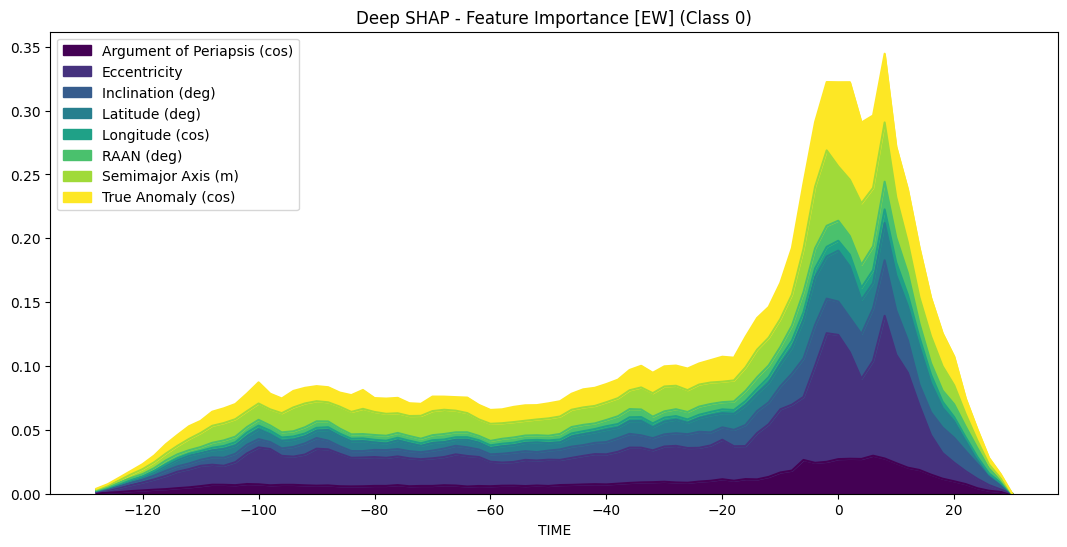

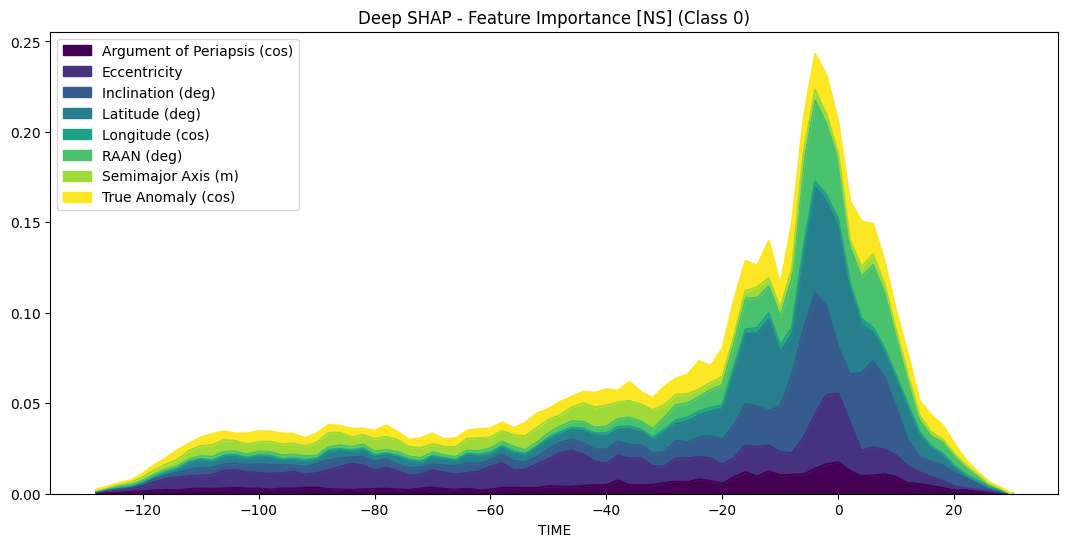

NameError: name 'class_mapping' is not defined

In [13]:
for class_output in range(shap_values_ew.shape[0]):
    ft_cols = ds_gen._input_features + [ft+'(mean overview)' for ft in ds_gen._overview_features_mean] + [ft+'(std overview)' for ft in ds_gen._overview_features_std]
    df_ew = pd.DataFrame(shap_values_ew[class_output,:,:], columns=ft_cols)
    df_ew['TIME'] = range(-128,32,2)

    df_ns = pd.DataFrame(shap_values_ns[class_output,:,:], columns=ft_cols)
    df_ns['TIME'] = range(-128,32,2)
    
    df_ew.plot.area(x='TIME',figsize=(13, 6), cmap='viridis')
    plt.title(f"Deep SHAP - Feature Importance [EW] (Class {class_output})")
    plt.show()

    df_ns.plot.area(x='TIME',figsize=(13, 6), cmap='viridis')
    plt.title(f"Deep SHAP - Feature Importance [NS] (Class {class_output})")
    plt.show()

    plot_ft_importance_bars(df_ew, df_ns, ft_cols, start_idx=0, end_idx=-1, title_addition=f'(Class )')